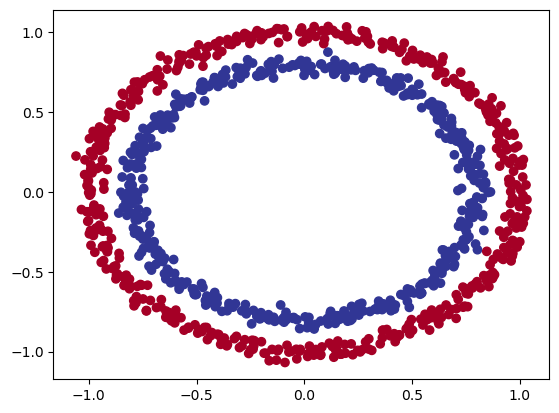

In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import torch
from torch import nn

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values


plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [2]:
#Train Test Split

# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

# Device Agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

def move_to_device(x):
    x = torch.from_numpy(x).type(torch.float).to(device)
    return x

X_train = move_to_device(X_train)
X_test = move_to_device(X_test)
y_train = move_to_device(y_train)
y_test = move_to_device(y_test)

In [3]:
# Create model class with two linear layers using nn.Sequential

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1),
        )

    def forward(self, x):
        return self.two_linear_layers(x)

In [4]:
#Calculate Accuracy

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [5]:
# model_0.eval()
# with torch.inference_mode():
#     y_logits = model_0(X_test[:3])
#
# #For prediction probability values, we need to perfrom a range-style rounding after applying the sigmoid function
#     y_pred_probs = torch.sigmoid(y_logits)
#     y_pred_probs = torch.round(y_pred_probs)
#     print(y_logits,y_pred_probs)

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = CircleModelV0().to(device)

loss_func = nn.BCEWithLogitsLoss() #Sigmoid activation function with Binary Cross Entropy Loss

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.05)

#Number of Epochs

epochs = 1000

train_loss_values = torch.empty(epochs, requires_grad=False).to(device)
test_loss_values = torch.empty(epochs, requires_grad=False).to(device)
train_acc_values = torch.empty(epochs, requires_grad=False).to(device)
test_acc_values = torch.empty(epochs, requires_grad=False).to(device)
epoch_count = torch.empty(epochs, requires_grad=False).to(device)


for epoch in range(epochs):
    #Training Mode
    model_0.train()
    #Forward Pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Raw Logits -> Pred Probs -> Pred Labels
    # Loss/Accuracy
    loss = loss_func(y_logits,
                     y_train) #BCEwithlogits expect logits input to calculate loss

    acc = accuracy_fn(y_true= y_train,
                      y_pred=y_pred)

    #Optimizer
    optimizer.zero_grad()

    # Loss Backwards (back prop)
    loss.backward()

    #Optimizerstep (grad desc)
    optimizer.step()

    #Try out test
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_func(test_logits, y_test)

        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

        epoch_count[[epoch]] = epoch
        test_loss_values[[epoch]] = test_loss
        test_acc_values[[epoch]] = test_acc
        train_loss_values[[epoch]] = loss
        train_acc_values[[epoch]] = acc

        if epoch %100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69479 | Acc: 46.38% | Test Loss: 0.69253 | Test Acc: 51.50%
Epoch: 100 | Loss: 0.68356 | Acc: 59.00% | Test Loss: 0.68664 | Test Acc: 56.00%
Epoch: 200 | Loss: 0.67291 | Acc: 72.88% | Test Loss: 0.67894 | Test Acc: 68.00%
Epoch: 300 | Loss: 0.65946 | Acc: 80.62% | Test Loss: 0.66805 | Test Acc: 73.00%
Epoch: 400 | Loss: 0.64047 | Acc: 87.25% | Test Loss: 0.65176 | Test Acc: 82.50%
Epoch: 500 | Loss: 0.61186 | Acc: 93.38% | Test Loss: 0.62701 | Test Acc: 89.50%
Epoch: 600 | Loss: 0.56963 | Acc: 98.12% | Test Loss: 0.59013 | Test Acc: 96.50%
Epoch: 700 | Loss: 0.50891 | Acc: 99.12% | Test Loss: 0.53663 | Test Acc: 98.00%
Epoch: 800 | Loss: 0.42961 | Acc: 99.50% | Test Loss: 0.46530 | Test Acc: 98.50%
Epoch: 900 | Loss: 0.34044 | Acc: 99.62% | Test Loss: 0.38261 | Test Acc: 98.50%


In [13]:
# Plot decision boundary
from helper_functions import plot_predictions, plot_decision_boundary

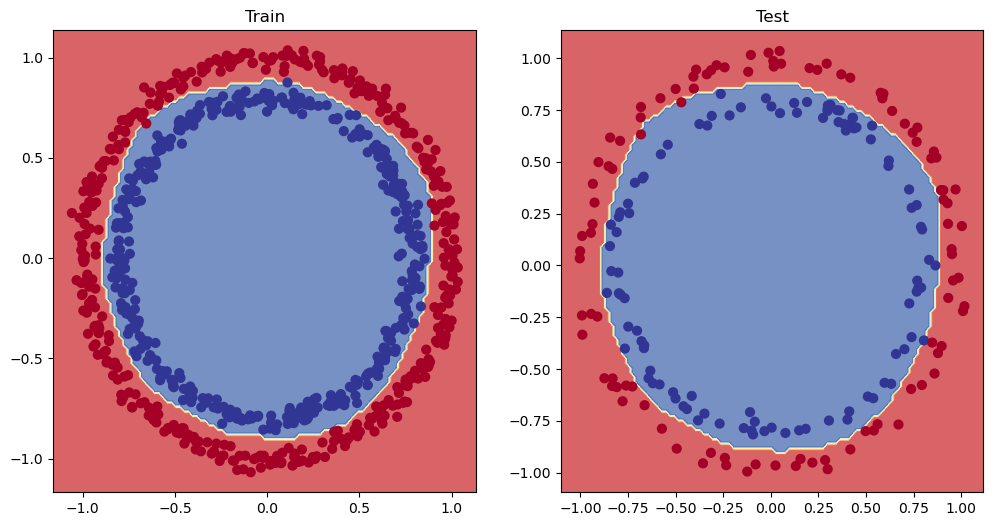

In [14]:
model_0.eval()
with torch.inference_mode():
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Train")
    plot_decision_boundary(model_0, X_train, y_train)
    plt.subplot(1,2,2)
    plt.title('Test')
    plot_decision_boundary(model_0, X_test, y_test)